In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from embeddings.dataloader import TheDataSet
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter



In [2]:
encoder_training_epochs = 150
# dataset_file = 'data_ae_train/fulldata.npy'
dataset_file = 'data/fulldata.npy'

In [3]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f"runs/autoencoder_experiment_{encoder_training_epochs}")


## AutoEncoder


In [4]:
%%writefile embeddings/autoencoder.py

import torch
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=256 , bias=True),
            nn.Tanh(),
            nn.Linear(in_features=256, out_features=128, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=32, bias=True),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=32, out_features=128, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=256, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=256, out_features=num_features, bias=True ),
            #nn.Sigmoid()
            nn.Tanh()
#             nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Overwriting embeddings/autoencoder.py


In [5]:
from embeddings.autoencoder import Autoencoder

## Training

In [6]:
def train(model, dataset, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    # criterion = nn.MSELoss() # mean square error loss
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    outputs = []
    losses = []
    for epoch in range(num_epochs):
        for X, y in train_loader:
            recon = model(X.float())
            loss = criterion(recon, X.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        losses.append(float(loss))
        writer.add_scalar(f'training loss {num_epochs}',
                            loss,
                            epoch * len(train_loader))
    return outputs, losses

In [7]:
dataset = TheDataSet(datafile=dataset_file, pad_to_360=False)
model = Autoencoder(num_features=dataset.num_features())
print(model)
max_epochs = encoder_training_epochs
outputs, losses = train(model, dataset=dataset, num_epochs=max_epochs, batch_size = 64, learning_rate=1e-3)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=338, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=338, bias=True)
    (5): Tanh()
  )
)
Epoch:1, Loss:0.1464
Epoch:2, Loss:0.1419
Epoch:3, Loss:0.1555
Epoch:4, Loss:0.1251
Epoch:5, Loss:0.1205
Epoch:6, Loss:0.1244
Epoch:7, Loss:0.1193
Epoch:8, Loss:0.1280
Epoch:9, Loss:0.1262
Epoch:10, Loss:0.1352
Epoch:11, Loss:0.1292
Epoch:12, Loss:0.0952
Epoch:13, Loss:0.1031
Epoch:14, Loss:0.1181
Epoch:15, Loss:0.1095
Epoch:16, Loss:0.1405
Epoch:17, Loss:0.1126
Epoch:18, Loss:0.1080
Epoch:19, Loss:0.1257
Epoch:20, Loss:0.1178
Epoch:21, Loss:0.1115
Epoch:22

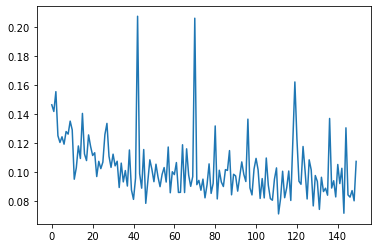

In [8]:
fig = plt.figure()
ax = plt.axes()

# x = np.linspace(0, 10, 1000)
ax.plot(losses);

In [9]:
# persist the encoder


with open('data/autoencoder.pic', 'bw') as f:
    torch.save(model, f, pickle_protocol=4)




In [10]:
with open('data/autoencoder.pic', 'rb') as f:
    autoencoder = torch.load(f)